# *Modules

In [1]:
from glob import glob
import sys
import os
# import psutil
from os.path import join, dirname
from os.path import getsize

import pickle as pkl
import numpy as np
import pandas as pd
import scipy.stats
import statannot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest

from tqdm import tqdm

In [2]:
%matplotlib inline

# font = {
#     'family': 'normal'
#     , 'weight': 'bold'
#     , 'size': 22
# }
# matplotlib.rc('font', **font)

$\textbf{Nilearn}$ enables approachable and versatile analyses of brain volumes. It provides statistical and machine-learning tools : https://nilearn.github.io/

In [3]:
# import nilearn.masking
from nilearn import plotting as nplt
from nilearn import image as niimg
import nilearn.decoding

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


$\textbf{Scikit-learn}$ is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities : https://scikit-learn.org/stable/#

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import LinearSVC

In [5]:
from datetime import date
today = date.today().strftime("%Y%m%d")

# *Create variables that point to the location of the configuration

In [6]:
dir_script = '.'
dir_root = '/home/sungbeenpark/GA'
dir_data = '/mnt/sda2/GA'

In [7]:
dir_fmri = dir_data + '/fmri_data'
dir_LSS = dir_fmri + '/preproc_data/beta_map'
dir_mask = dir_fmri + '/masks'
dir_loc = dir_mask + '/localizer'
dir_fig = dir_root

In [8]:
## experimental properties
list_subj = np.array(
    ['01', '02', '05', '07', '08', '11', '12', '13', '14', '15'
     ,'18', '19', '20', '21', '23', '26', '27', '28', '29', '30'
     ,'31', '32', '33', '34', '35', '36', '37', '38', '42', '44']
)
list_stage = np.array(
    ['early_practice', 'early_unpractice', 'late_practice', 'late_unpractice']
)
list_run = np.array(
    ['r%02d'%(r+1) for r in range(6)]
)

In [9]:
## labeling with target position
# 1 - 5 - 25 - 21 - 1 - 25 - 5 - 21 - 25 - 1 - 21 - 5 - 1 - ...
##################
#  1  2  3  4  5 #
#  6  7  8  9 10 #
# 11 12 13 14 15 #
# 16 17 18 19 20 #
# 21 22 23 24 25 #
##################
target_pos = []

with open(join(dir_script,'targetID.txt')) as file:
    for line in file:
        target_pos.append(int(line.strip()))
        
target_pos = target_pos[1:97]
# target_path = list(range(1,13))*8

In [10]:
## background image
img_bg = join('/mnt/sda2/MNI152_2009_template.nii.gz')

In [11]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

# *MVPA
#### Multi-voxel pattern analysis (MVPA) is gaining increasing interest in the neuroimaging community because it allows to detect differences between conditions with higher sensitivity than conventional univariate analysis by focusing on the analysis and comparison of distributed patterns of activity. In such a multivariate approach, data from individual voxels within a region are jointly analyzed. Furthermore, MVPA is often presented in the context of "brain reading" applications reporting that specific mental states or representational content can be decoded from fMRI activity patterns after performing a "training" or "learning phase. In this context, MVPA tools are often referred to as classifiers or, more generally, learning machines. The latter names stress that many MVPA tools originate from a field called machine learning, a branch of artificial intelligence.

## *Data table

#### - behavioural data

In [12]:
## load data (2 days, 30 subjects, 48 blocks)
with open(join('/home/sungbeenpark/Github/labs/GA/behav_data/RewardRate.pkl'), 'rb') as f:
    tmp = pkl.load(f)
print(tmp.shape)

## (visit, subj, run)=(2, 30, 6) 포맷에 맞춰서 정리
behav = np.ones((2,30,6)) * np.nan
for rr, _ in enumerate(list_run):
    behav[:,:,rr] = np.mean(tmp[:,:,8*rr:8*(rr+1)], axis=-1)
print(behav.shape)

(2, 30, 48)
(2, 30, 6)


In [13]:
behav_prac = np.mean(behav[1,:,:3]-behav[0,:,:3], axis=1)
behav_unprac = np.mean(behav[1,:,3:]-behav[0,:,3:], axis=1)

#### - fMRI data: calculated by `calc.lda_score.20220222.py`

In [14]:
def load_lda_score(module):
    with open(join(dir_root, 'MVPA', 'cross_validate.%s.pkl'%module), 'rb') as f:
        df = pkl.load(f)
    
    for ii, stage in enumerate(df.stage):
        df.loc[ii,'visit'] = stage.split('_')[0]
        df.loc[ii, 'mapping'] = stage.split('_')[1]
    
    return df

In [15]:
def set_frame(Bbox, cp=[.5,.8]):
    ########################################################################
    ## Bbox: A bounding box                                               ## 
    ## cp: center point of a new Bbox, input Bbox의 가로, 세로를 1로 기준 ##
    ## ---------------------tr                                            ##
    ## |                    |                                             ##
    ## |                    |                                             ##
    ## |                    |                                             ##
    ## bl ------------------|                                             ##
    ########################################################################
    bl, tr = Bbox.get_points()
    ## top-right
    B = tr
    ## center
    r = np.array(cp)
    C = r*B + (1-r)*bl
    ## bottom-left
    A = 2*C - B
    ## adjusted bbox
    A = C + (A-C)*.9
    B = C + (B-C)*.9
    ## Rectangle
    rect = np.array([A, B-A])
    return np.concatenate(rect)

#### 1. DMN (3dUndump)

In [16]:
df = load_lda_score(module='DMN_3dUndump')
df

subj            stage          ROI      acc1      acc2      acc3  \
0      01   early_practice      Average  0.406250  0.375000  0.427083   
1      02   early_practice      Average  0.312500  0.395833  0.343750   
2      05   early_practice      Average  0.250000  0.416667  0.333333   
3      07   early_practice      Average  0.322917  0.395833  0.312500   
4      08   early_practice      Average  0.291667  0.270833  0.312500   
...   ...              ...          ...       ...       ...       ...   
2875   36  late_unpractice  dMsub_dMPFC  0.312500  0.281250  0.302083   
2876   37  late_unpractice  dMsub_dMPFC  0.250000  0.281250  0.322917   
2877   38  late_unpractice  dMsub_dMPFC  0.250000  0.250000  0.218750   
2878   42  late_unpractice  dMsub_dMPFC  0.312500  0.322917  0.281250   
2879   44  late_unpractice  dMsub_dMPFC  0.260417  0.291667  0.260417   

      mean_acc  visit     mapping  
0     0.402778  early    practice  
1     0.350694  early    practice  
2     0.333333  early    practice  
3     0.343750  early    practice  
4     0.291667  early    practice  
...        ...    ...         ...  
2875  0.298611   late  unpractice  
2876  0.284722   late  unpractice  
2877  0.239583   late  unpractice  
2878  0.305556   late  unpractice  
2879  0.270833   late  unpractice  

[2880 rows x 9 columns]

In [ ]:
fig, ax = plt.subplots(figsize=(60,12))

data=df
x='ROI'
y='mean_acc'
hue='stage'

ax = sns.barplot(
    data=data
    , x=x, y=y, hue=hue
    , ci=68, capsize=.15
    , ax=ax
)
ax.tick_params(axis='x', rotation=45)
ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.75)
ax.legend(prop={'size': 20}, bbox_to_anchor=(1.02,0.5), loc="center left", borderaxespad=0)
ax.set_xlabel('ROI', fontsize = 20)
ax.set_ylabel('Classification Rate', fontsize = 20)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor'
    , fontdict={'fontsize':12}
)
ax.grid(axis='y')
ax.set_ylim([0.24,.4])

list_region = [txt.get_text() for txt in ax.get_xticklabels()]
bar = {}
for x, container in enumerate(ax.containers):
    stage = container.get_label()
    ## x positions
    bar[stage] = [rect.xy[0] for rect in container.get_children()]
#     ax.bar_label(container, padding=3)
    
for idx, region in enumerate(list_region):
    ## practice
    A = data[(data.stage=='early_practice')&(data.ROI==region)].mean_acc
    B = data[(data.stage=='late_practice')&(data.ROI==region)].mean_acc
    tval, pval = scipy.stats.ttest_rel(a=A, b=B, alternative='two-sided')
    symbol = convert_pvalue_to_asterisks(pval)
    if symbol != "ns":
        x1, x2 = bar['early_practice'][idx]+.1, bar['late_practice'][idx]+.1
        y1, y2 = A.mean()+A.sem()+.01, B.mean()+B.sem()+.01
        h = max(y1, y2)
        print(region, symbol, x1,x2,y1,y2,h)
        ax.plot([x1, x1, x2, x2], [y1, h+.005, h+.005, y2], lw=1.5, c='k')
        ax.text(
            (x1+x2)*.5, h+.006
            , symbol
            , ha='center', va='bottom', fontdict={'fontsize': 20, 'color': 'k'}
        )
    ## unpractice
    A = data[(data.stage=='early_unpractice')&(data.ROI==region)].mean_acc
    B = data[(data.stage=='late_unpractice')&(data.ROI==region)].mean_acc
    tval, pval = scipy.stats.ttest_rel(a=A, b=B, alternative='two-sided')
    symbol = convert_pvalue_to_asterisks(pval)
    if symbol != "ns":
        x1, x2 = bar['early_unpractice'][idx]+.1, bar['late_unpractice'][idx]+.1
        y1, y2 = A.mean()+A.sem()+.01, B.mean()+B.sem()+.01
        h = max(y1, y2)
        ax.plot([x1, x1, x2, x2], [y1, h+.005, h+.005, y2], lw=1.5, c='k')
        ax.text(
            (x1+x2)*.5, h+.006
            , symbol
            , ha='center', va='bottom', fontdict={'fontsize': 20, 'color': 'k'}
        )
    ## check 
#     B = 0.25
#     for stage in list_stage:
#         x1 = bar[stage][idx]+.1
#         A = data[(data.stage==stage)&(data.ROI==region)].mean_acc
#         tval, pval = scipy.stats.ttest_1samp(a=A, popmean=B)
#         ax.text(
#             x1, A.mean()+A.sem()
#             , convert_pvalue_to_asterisks(pval)
#             , ha='center', va='bottom', fontdict={'fontsize': 20, 'color': 'k'}
#         )

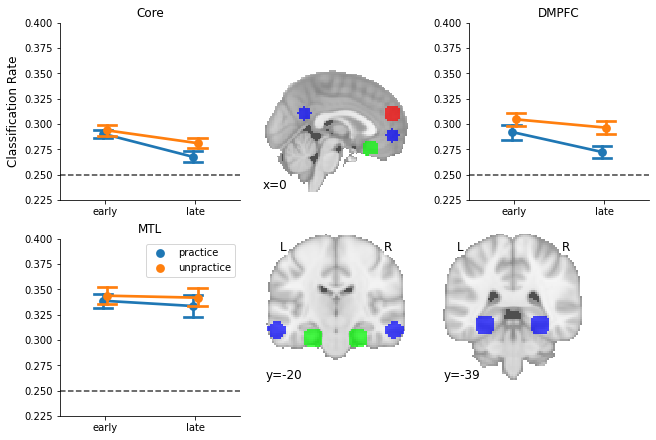

In [193]:
nrows, ncols = 2, 3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3, nrows*3), constrained_layout=True)

x='visit'
y='mean_acc'
hue='mapping'

## Core
data = df[df.ROI=='Core']
ax = sns.pointplot(
    data=data
    , x=x, y=y, hue=hue
    , ci=68, capsize=.2, dodge=True
    , ax=axs[0,0]
)
ax.set_xlabel(None)
ax.set_ylabel('Classification Rate', fontsize=12)
# ax.tick_params(axis='x', rotation=45)
ax.set_ylim([.225, .4])
ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.75)
ax.legend(title=None, loc='best')
# ax.legend(title=None, prop={'size': 12}, bbox_to_anchor=(-.3, 0.1))
# ax.get_legend().remove()
ax.set_title('Core')

## DMPFC
data = df[df.ROI=='dMsub']
ax = sns.pointplot(
    data=data
    , x=x, y=y, hue=hue
    , ci=68, capsize=.2, dodge=True
    , ax=axs[0,2]
)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_ylim([.225, .4])
ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.75)
ax.legend(title=None, loc='best')
# ax.get_legend().remove()
ax.set_title('DMPFC')

## MTL
data = df[df.ROI=='MTLsub']
ax = sns.pointplot(
    data=data
    , x=x, y=y, hue=hue
    , ci=68, capsize=.2, dodge=True
    , ax=axs[1,0]
)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_ylim([.225, .4])
ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.75)
ax.legend(title=None, loc='best')
ax.set_title('MTL')

# ax, test_results = statannot.add_stat_annotation(
#     ax, data=data, x=x, y=y, hue=hue
#     , box_pairs=[
#         (('early','practice'), ('late', 'practice'))
#         , (('early','unpractice'), ('late', 'unpractice'))
#     ]
#     , test='t-test_paired', text_format='star', loc='inside', verbose=2
#     , line_offset_to_box=-.4
# )

# ## ROIs
tmp = nilearn.image.math_img(img1=join(dir_mask,'DMN/Core.nii'), formula='img1>0')
tmp = nilearn.image.math_img(img1=tmp, img2=join(dir_mask,'DMN/dMsub.nii'), formula='img1 + 2*(img2>0)')
tmp = nilearn.image.math_img(img1=tmp, img2=join(dir_mask,'DMN/MTLsub.nii'), formula='img1 + 3*(img2>0)')
nilearn.plotting.plot_roi(
    tmp, black_bg=False
    , draw_cross=False, display_mode='x', cut_coords=[0]
    , cmap=plt.cm.brg, axes=axs[0,1]
)
nilearn.plotting.plot_roi(
    tmp, black_bg=False
    , draw_cross=False, display_mode='y', cut_coords=[-20]
    , cmap=plt.cm.brg, axes=axs[1,1]
)

nilearn.plotting.plot_roi(
    tmp, black_bg=False
    , draw_cross=False, display_mode='y', cut_coords=[-39]
    , cmap=plt.cm.brg, axes=axs[1,2]
)

sns.despine()
# fig.tight_layout()

In [38]:
# fig.savefig(join(dir_fig, 'decoding.DMN_3dUndump.png'), dpi=300)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

early_practice v.s. late_practice: t-test paired samples with Bonferroni correction, P_val=9.772e-03 stat=3.047e+00
early_unpractice v.s. late_unpractice: t-test paired samples with Bonferroni correction, P_val=1.078e-01 stat=2.009e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

early_practice v.s. late_practice: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=4.125e-01
early_unpractice v.s. late_unpractice: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=2.026e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

early_practice v.s. late_practice: t

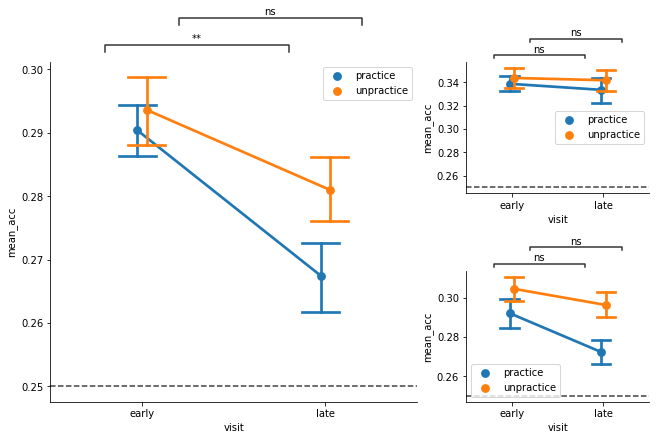

In [23]:
nrows, ncols = 2, 3
fig = plt.figure(figsize=(ncols*3, nrows*3), constrained_layout=True)
gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

axs = []
axs.append(fig.add_subplot(gs[:, :2]))
axs.append(fig.add_subplot(gs[0, 2]))
axs.append(fig.add_subplot(gs[1, 2]))

rois = ['Core', 'MTLsub', 'dMsub']

x='visit'
y='mean_acc'
hue='mapping'

for ii, roi in enumerate(rois):
    ax = axs[ii]
    
    data = df[df.ROI==roi]
    ax = sns.pointplot(
        data=data
        , x=x, y=y, hue=hue
        , ci=68, capsize=.2
        , title=roi, ax=ax
        , dodge=True
    )
    ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.75)
#     ax.set_title(roi)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend()
    
    ax, test_results = statannot.add_stat_annotation(
        ax, data=data, x=x, y=y, hue=hue
        , box_pairs=[
            (('early','practice'), ('late', 'practice'))
            , (('early','unpractice'), ('late', 'unpractice'))
        ]
        , test='t-test_paired', text_format='star', loc='outside', verbose=2
#         , line_offset_to_box=0.2, line_offset=0.2, line_height=0.05, text_offset=1
    )
sns.despine()
# fig.tight_layout()

#### 2. DMN (fan)

In [21]:
df = load_lda_score('DMN_fan')
df

subj            stage        ROI      acc1      acc2      acc3  mean_acc  \
0      01   early_practice  SFG_L_7_2  0.270833  0.343750  0.343750  0.319444   
1      02   early_practice  SFG_L_7_2  0.239583  0.312500  0.302083  0.284722   
2      05   early_practice  SFG_L_7_2  0.250000  0.281250  0.281250  0.270833   
3      07   early_practice  SFG_L_7_2  0.333333  0.270833  0.312500  0.305556   
4      08   early_practice  SFG_L_7_2  0.291667  0.270833  0.333333  0.298611   
...   ...              ...        ...       ...       ...       ...       ...   
4315   36  late_unpractice   CG_R_7_7  0.218750  0.229167  0.312500  0.253472   
4316   37  late_unpractice   CG_R_7_7  0.260417  0.260417  0.239583  0.253472   
4317   38  late_unpractice   CG_R_7_7  0.333333  0.208333  0.239583  0.260417   
4318   42  late_unpractice   CG_R_7_7  0.312500  0.302083  0.364583  0.326389   
4319   44  late_unpractice   CG_R_7_7  0.250000  0.260417  0.156250  0.222222   

      visit     mapping  
0     early    practice  
1     early    practice  
2     early    practice  
3     early    practice  
4     early    practice  
...     ...         ...  
4315   late  unpractice  
4316   late  unpractice  
4317   late  unpractice  
4318   late  unpractice  
4319   late  unpractice  

[4320 rows x 9 columns]

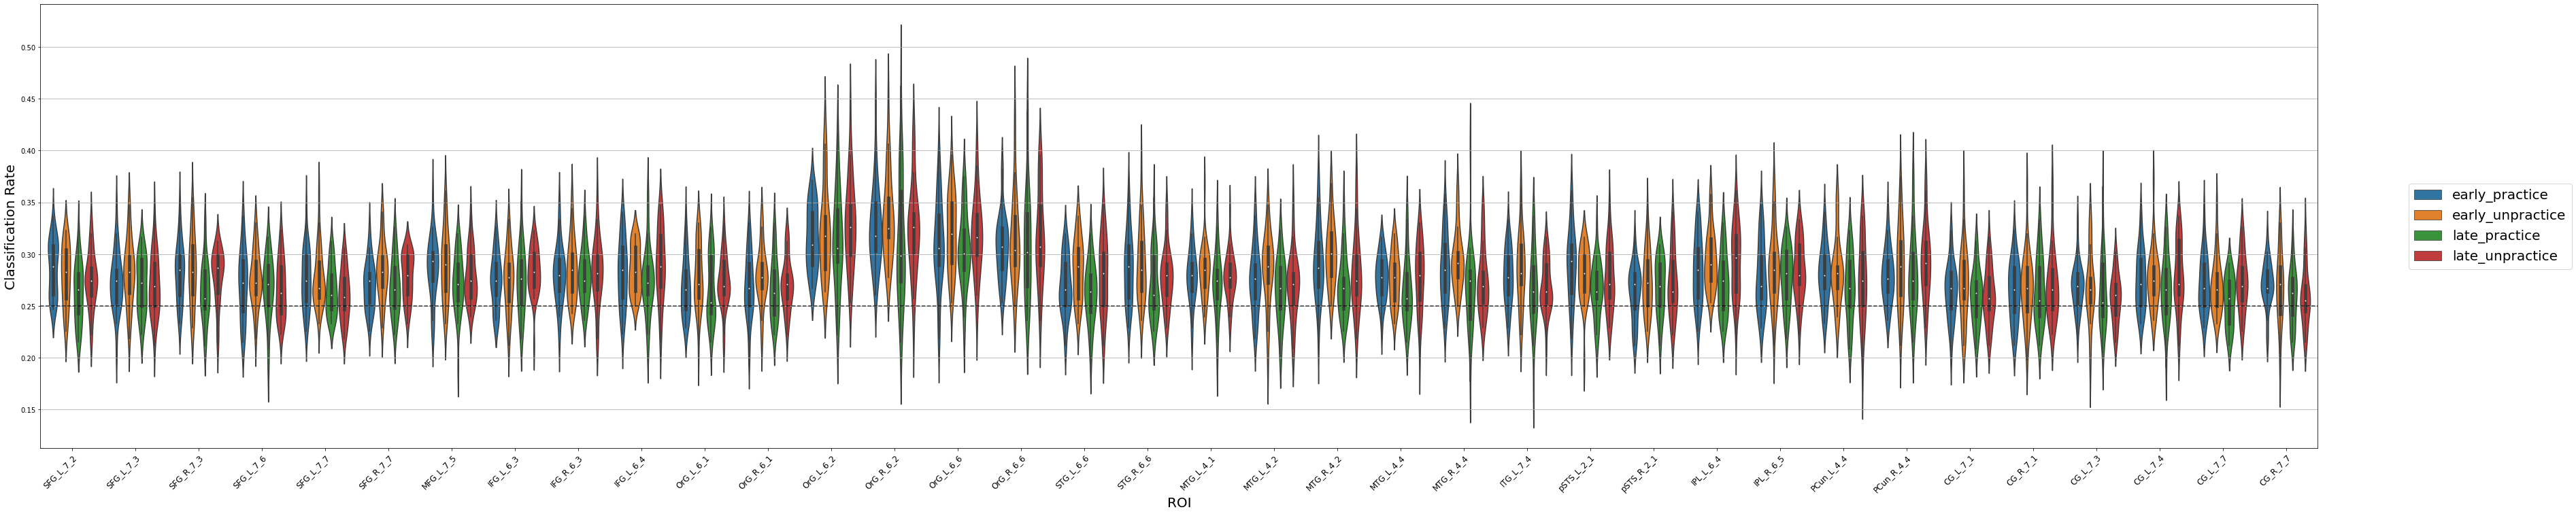

In [22]:
fig, ax = plt.subplots(figsize=(60,12))

ax = sns.violinplot(
    data=df
    , x='ROI', y='mean_acc', hue='stage'
#     , capsize=.1, ci=68, dodge=True
    , ax=ax
)
ax.tick_params(axis='x', rotation=45)
ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.75)
ax.legend(prop={'size': 20}, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
ax.set_xlabel('ROI', fontsize = 20)
ax.set_ylabel('Classification Rate', fontsize = 20)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor'
    , fontdict={'fontsize':12}
)
ax.grid(axis='y')
# ax.set_ylim([0,.5])

#### 3. Localizer

In [194]:
df = load_lda_score('localizer')
df

subj            stage                    ROI      acc1      acc2  \
0     01   early_practice  n200_c1_L_Postcentral  0.322917  0.427083   
1     02   early_practice  n200_c1_L_Postcentral  0.270833  0.333333   
2     05   early_practice  n200_c1_L_Postcentral  0.364583  0.375000   
3     07   early_practice  n200_c1_L_Postcentral  0.395833  0.260417   
4     08   early_practice  n200_c1_L_Postcentral  0.322917  0.406250   
..   ...              ...                    ...       ...       ...   
835   36  late_unpractice     n200_c7_L_Thalamus  0.260417  0.250000   
836   37  late_unpractice     n200_c7_L_Thalamus  0.250000  0.239583   
837   38  late_unpractice     n200_c7_L_Thalamus  0.343750  0.239583   
838   42  late_unpractice     n200_c7_L_Thalamus  0.218750  0.229167   
839   44  late_unpractice     n200_c7_L_Thalamus  0.260417  0.218750   

         acc3  mean_acc  visit     mapping  
0    0.385417  0.378472  early    practice  
1    0.302083  0.302083  early    practice  
2    0.229167  0.322917  early    practice  
3    0.208333  0.288194  early    practice  
4    0.375000  0.368056  early    practice  
..        ...       ...    ...         ...  
835  0.291667  0.267361   late  unpractice  
836  0.187500  0.225694   late  unpractice  
837  0.291667  0.291667   late  unpractice  
838  0.302083  0.250000   late  unpractice  
839  0.229167  0.236111   late  unpractice  

[840 rows x 9 columns]

n200_c1_L_Postcentral **** -0.30000000000000004 0.10000000000000003 0.34864962405358324 0.4428930073751449 0.4428930073751449


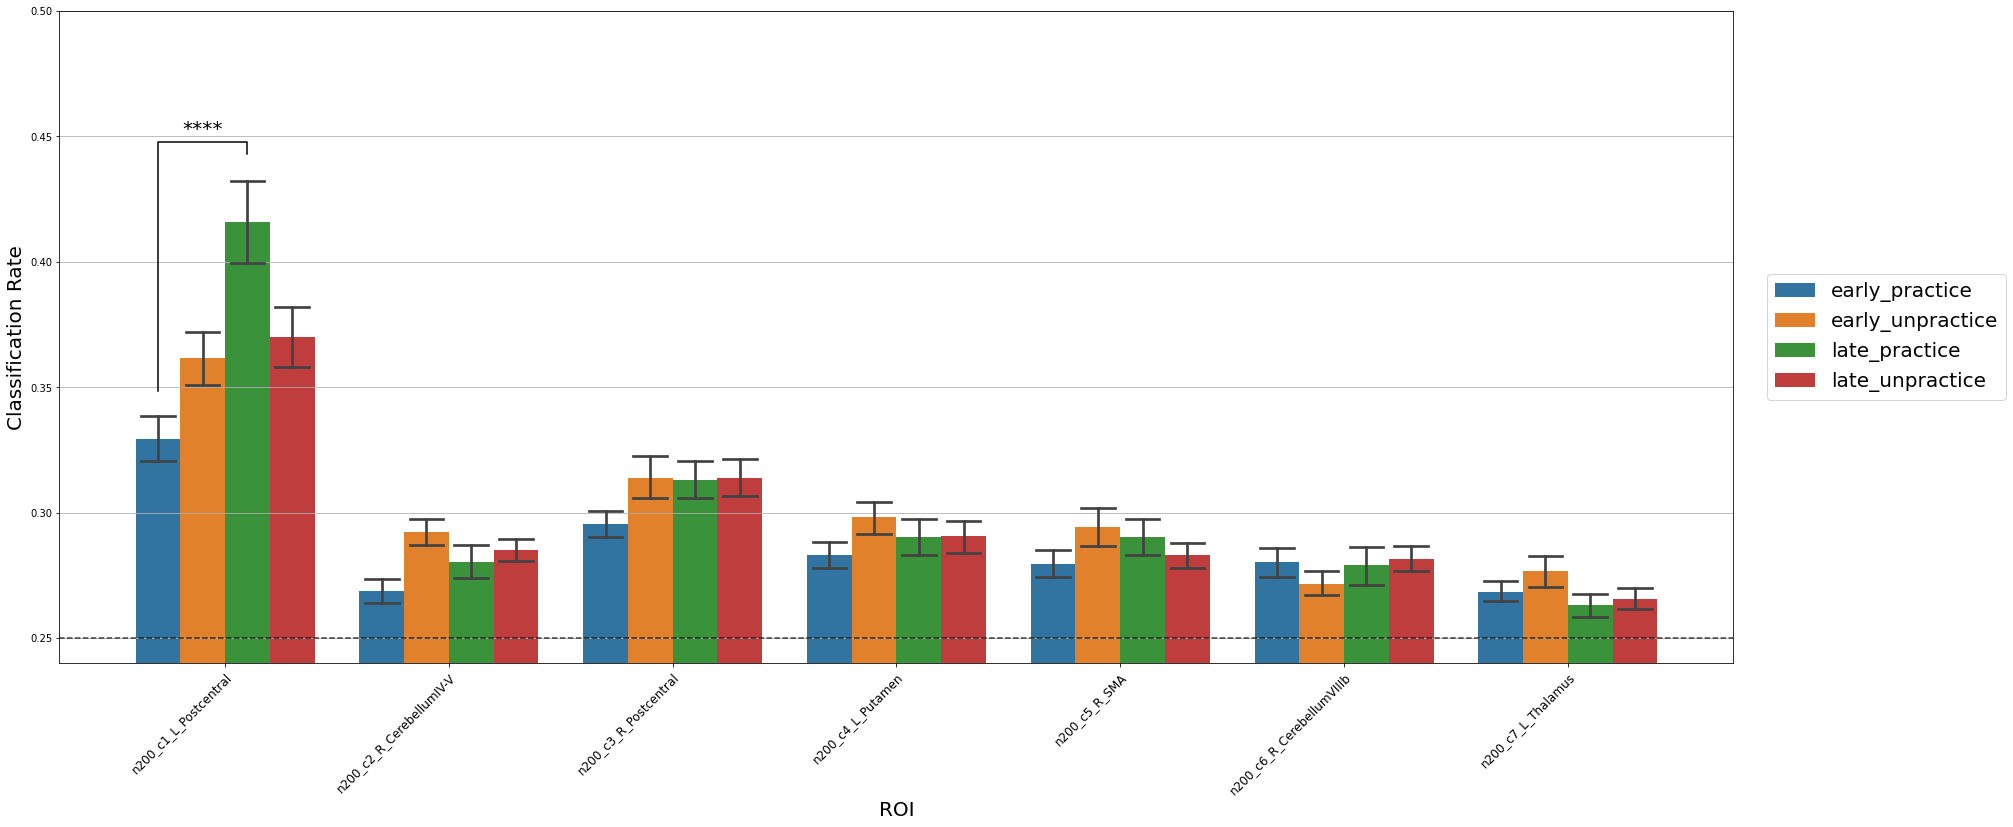

In [198]:
fig, ax = plt.subplots(figsize=(30,12))
data=df
x='ROI'
y='mean_acc'
hue='stage'

ax = sns.barplot(
    data=data
    , x=x, y=y, hue=hue
    , ci=68, capsize=.15
    , ax=ax
)
ax.tick_params(axis='x', rotation=45)
ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.75)
ax.legend(prop={'size': 20}, bbox_to_anchor=(1.02,0.5), loc="center left", borderaxespad=0)
ax.set_xlabel('ROI', fontsize = 20)
ax.set_ylabel('Classification Rate', fontsize = 20)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor'
    , fontdict={'fontsize':12}
)
ax.grid(axis='y')
ax.set_ylim([0.24,.5])

bar = {}
for x, container in enumerate(ax.containers):
    stage = container.get_label()
    ## x positions
    bar[stage] = [rect.xy[0] for rect in container.get_children()]
    
regions = [txt.get_text() for txt in ax.get_xticklabels()]
for idx, region in enumerate(regions):
    ## practice
    A = data[(data.stage=='early_practice')&(data.ROI==region)].mean_acc
    B = data[(data.stage=='late_practice')&(data.ROI==region)].mean_acc
    tval, pval = scipy.stats.ttest_rel(a=A, b=B, alternative='two-sided')
    symbol = convert_pvalue_to_asterisks(pval)
    if symbol != "ns":
        x1, x2 = bar['early_practice'][idx]+.1, bar['late_practice'][idx]+.1
        y1, y2 = A.mean()+A.sem()+.01, B.mean()+B.sem()+.01
        h = max(y1, y2)
        print(region, symbol, x1,x2,y1,y2,h)
        ax.plot([x1, x1, x2, x2], [y1, h+.005, h+.005, y2], lw=1.5, c='k')
        ax.text(
            (x1+x2)*.5, h+.006
            , symbol
            , ha='center', va='bottom', fontdict={'fontsize': 20, 'color': 'k'}
        )
    ## unpractice
    A = data[(data.stage=='early_unpractice')&(data.ROI==region)].mean_acc
    B = data[(data.stage=='late_unpractice')&(data.ROI==region)].mean_acc
    tval, pval = scipy.stats.ttest_rel(a=A, b=B, alternative='two-sided')
    symbol = convert_pvalue_to_asterisks(pval)
    if symbol != "ns":
        x1, x2 = bar['early_unpractice'][idx]+.1, bar['late_unpractice'][idx]+.1
        y1, y2 = A.mean()+A.sem()+.01, B.mean()+B.sem()+.01
        h = max(y1, y2)
        ax.plot([x1, x1, x2, x2], [y1, h+.005, h+.005, y2], lw=1.5, c='k')
        ax.text(
            (x1+x2)*.5, h+.006
            , symbol
            , ha='center', va='bottom', fontdict={'fontsize': 20, 'color': 'k'}
        )

['n200_c1_L_Postcentral', 'n200_c2_R_CerebellumIV-V', 'n200_c3_R_Postcentral', 'n200_c4_L_Putamen', 'n200_c5_R_SMA', 'n200_c6_R_CerebellumVIIIb', 'n200_c7_L_Thalamus']


/tmp/ipykernel_415943/3649744830.py:71: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


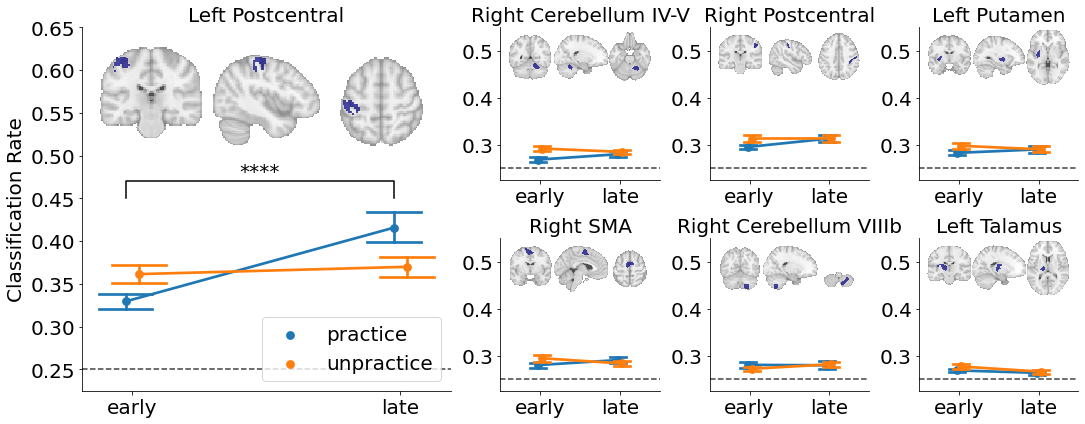

In [92]:
nrows, ncols = 2, 5
fig = plt.figure(figsize=(ncols*3, nrows*3), constrained_layout=True)
gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

axs = []
axs.append(fig.add_subplot(gs[:, :2]))
axs.append(fig.add_subplot(gs[0, 2]))
axs.append(fig.add_subplot(gs[0, 3]))
axs.append(fig.add_subplot(gs[0, 4]))
axs.append(fig.add_subplot(gs[1, 2]))
axs.append(fig.add_subplot(gs[1, 3]))
axs.append(fig.add_subplot(gs[1, 4]))

list_ = sorted(df.ROI.unique())
print(list_)
rois_rename = ['Left Postcentral'
               , 'Right Cerebellum IV-V'
               , 'Right Postcentral'
               , 'Left Putamen'
               , 'Right SMA'
               , 'Right Cerebellum VIIIb'
               , 'Left Talamus']

## classification rates
x='visit'
y='mean_acc'
hue='mapping'
for ii, roi in enumerate(list_):
    ax = axs[ii]

    data = df[df.ROI==roi]
#     A = data[(data.mapping=='practice')&(data.visit=='early')].mean_acc
#     B = data[(data.mapping=='practice')&(data.visit=='late')].mean_acc
#     tval, pval = scipy.stats.ttest_rel(A,B)
#     print(ii, pval)
    ax = sns.pointplot(
        data=data
        , x=x, y=y, hue=hue
        , ci=68, capsize=.2, dodge=True
        , ax=ax
    )
    ax.set_title(rois_rename[ii], fontsize=20)
    ax.set_xlabel(None)
    ax.set_ylim([.225, .55])
    ax.tick_params(labelsize=20)
    ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.75)
    # ax.legend(title=None, prop={'size': 12}, bbox_to_anchor=(-.3, 0.1))
    if ii>0:
        ax.get_legend().remove()
        ax.set_ylabel(None)
    else:
        ax.set_ylim([.225, .65])
        ax.set_ylabel('Classification Rate', fontsize=20)
        ax.legend(title=None, loc='lower right', fontsize=20)
        
        ## statistical annotation
        ep = 0.025
        x1, x2 = 0-ep, 1-ep # columns 'early' and 'late' (first column: 0, see plt.xticks())
        y0, h = 0.45, 0.02
        ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1.5, c='k')
        
        A = data[(data.mapping=='practice')&(data.visit=='early')].mean_acc
        B = data[(data.mapping=='practice')&(data.visit=='late')].mean_acc
        tval, pval = scipy.stats.ttest_rel(A,B)
        ax.text(
            (x1+x2)*.5, y0+h
            , convert_pvalue_to_asterisks(pval)
            , ha='center', va='bottom', fontdict={'fontsize': 20, 'color': 'k'}
        )

fig.tight_layout()

## ROIs
axs= fig.get_axes()
for ii, ax in enumerate(axs):
    roi = ax.get_title()
    ## Bounding box
    bbox = ax.get_position()
    rect = set_frame(bbox)
    ax_insert = fig.add_axes(rect)
    nilearn.plotting.plot_roi(
        join(dir_loc, '%s_mask.nii'%list_[ii])
        , annotate=False
        , draw_cross=False, axes=ax_insert
    )

sns.despine()

In [93]:
fig.savefig(join(dir_fig, 'decoding.localizer.png'), dpi=300)

#### 4. Visiual Area

In [199]:
df = load_lda_score('vision')
df

subj            stage         ROI      acc1      acc2      acc3  \
0      01   early_practice   FuG_L_3_2  0.489583  0.427083  0.562500   
1      02   early_practice   FuG_L_3_2  0.500000  0.500000  0.468750   
2      05   early_practice   FuG_L_3_2  0.427083  0.468750  0.406250   
3      07   early_practice   FuG_L_3_2  0.406250  0.416667  0.468750   
4      08   early_practice   FuG_L_3_2  0.281250  0.354167  0.312500   
...   ...              ...         ...       ...       ...       ...   
4075   36  late_unpractice  LOcC_R_2_2  0.375000  0.364583  0.364583   
4076   37  late_unpractice  LOcC_R_2_2  0.270833  0.260417  0.260417   
4077   38  late_unpractice  LOcC_R_2_2  0.375000  0.427083  0.343750   
4078   42  late_unpractice  LOcC_R_2_2  0.260417  0.312500  0.270833   
4079   44  late_unpractice  LOcC_R_2_2  0.333333  0.385417  0.354167   

      mean_acc  visit     mapping  
0     0.493056  early    practice  
1     0.489583  early    practice  
2     0.434028  early    practice  
3     0.430556  early    practice  
4     0.315972  early    practice  
...        ...    ...         ...  
4075  0.368056   late  unpractice  
4076  0.263889   late  unpractice  
4077  0.381944   late  unpractice  
4078  0.281250   late  unpractice  
4079  0.357639   late  unpractice  

[4080 rows x 9 columns]

In [203]:
fig, ax = plt.subplots(figsize=(60,12))
data=df
x='ROI'
y='mean_acc'
hue='stage'

ax = sns.barplot(
    data=data
    , x=x, y=y, hue=hue
    , ci=68, capsize=.15
    , ax=ax
)
ax.tick_params(axis='x', rotation=45)
ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.75)
ax.legend(prop={'size': 20}, bbox_to_anchor=(1.02,0.5), loc="center left", borderaxespad=0)
ax.set_xlabel('ROI', fontsize = 20)
ax.set_ylabel('Classification Rate', fontsize = 20)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor'
    , fontdict={'fontsize':12}
)
ax.grid(axis='y')
ax.set_ylim([0.24,.8])

bar = {}
for x, container in enumerate(ax.containers):
    stage = container.get_label()
    ## x positions
    bar[stage] = [rect.xy[0] for rect in container.get_children()]
    
regions = [txt.get_text() for txt in ax.get_xticklabels()]
for idx, region in enumerate(regions):
    ## practice
    A = data[(data.stage=='early_practice')&(data.ROI==region)].mean_acc
    B = data[(data.stage=='late_practice')&(data.ROI==region)].mean_acc
    tval, pval = scipy.stats.ttest_rel(a=A, b=B, alternative='two-sided')
    symbol = convert_pvalue_to_asterisks(pval)
    if symbol != "ns":
        x1, x2 = bar['early_practice'][idx]+.1, bar['late_practice'][idx]+.1
        y1, y2 = A.mean()+A.sem()+.01, B.mean()+B.sem()+.01
        h = max(y1, y2)
        print(region, symbol, x1,x2,y1,y2,h)
        ax.plot([x1, x1, x2, x2], [y1, h+.005, h+.005, y2], lw=1.5, c='k')
        ax.text(
            (x1+x2)*.5, h+.006
            , symbol
            , ha='center', va='bottom', fontdict={'fontsize': 20, 'color': 'k'}
        )
    ## unpractice
    A = data[(data.stage=='early_unpractice')&(data.ROI==region)].mean_acc
    B = data[(data.stage=='late_unpractice')&(data.ROI==region)].mean_acc
    tval, pval = scipy.stats.ttest_rel(a=A, b=B, alternative='two-sided')
    symbol = convert_pvalue_to_asterisks(pval)
    if symbol != "ns":
        x1, x2 = bar['early_unpractice'][idx]+.1, bar['late_unpractice'][idx]+.1
        y1, y2 = A.mean()+A.sem()+.01, B.mean()+B.sem()+.01
        h = max(y1, y2)
        ax.plot([x1, x1, x2, x2], [y1, h+.005, h+.005, y2], lw=1.5, c='k')
        ax.text(
            (x1+x2)*.5, h+.006
            , symbol
            , ha='center', va='bottom', fontdict={'fontsize': 20, 'color': 'k'}
        )

MVOcC_L_5_1 ** 12.7 13.1 0.6110780721796678 0.6984496928334483 0.6984496928334483
MVOcC_R_5_1 ** 13.7 14.1 0.6098328694808245 0.7101360990355304 0.7101360990355304
MVOcC_L_5_2 ** 14.7 15.1 0.5587262559537647 0.6542343213424044 0.6542343213424044
MVOcC_R_5_2 ** 15.7 16.1 0.5700636372957733 0.6736762986586442 0.6736762986586442
MVOcC_L_5_3 ** 16.7 17.1 0.6548984156798902 0.7535065748018891 0.7535065748018891
MVOcC_R_5_3 * 17.7 18.1 0.6004224225667697 0.6937196942609016 0.6937196942609016
MVOcC_R_5_4 * 19.7 20.1 0.49312658093168815 0.5574310771651386 0.5574310771651386
MVOcC_R_5_5 * 21.7 22.1 0.40582795072249894 0.4582869321171114 0.4582869321171114
LOcC_R_4_3 * 26.7 27.1 0.5725876331884231 0.6446578227262676 0.6446578227262676
LOcC_L_4_4 * 27.7 28.1 0.5220397487075311 0.5931207382418557 0.5931207382418557
LOcC_R_4_4 * 28.7 29.1 0.4991894418299503 0.5679361356041883 0.5679361356041883


In [27]:
fan_info = pd.read_csv(join(dir_mask,'fan280','fan_cluster_net_20200121.csv'), sep=',', index_col=0)

dt = pd.DataFrame()
for network7 in [1]:
    dt = dt.append(fan_info[(fan_info.yeo_7network == network7)])

img_roi = {}
for idx in dt.index:
    label = dt.loc[idx,'label']
    region = dt.loc[idx,'region']

    img_roi[region] = nilearn.image.load_img(
            join(dir_fmri, 'masks/fan280/fan.roi.GA.%03d.nii.gz'%int(label))
    )
    
## Merge them
for ii, img in enumerate(img_roi.values()):
    if ii>0:
        fan = nilearn.image.math_img(img1=fan, img2=img, formula='(img1+img2)>0')
    else:
        fan = img
        
nilearn.plotting.plot_roi(fan)

In [28]:
fig, ax = plt.subplots()

data = df[df.ROI=='total']
x='visit'
y='mean_acc'
hue='mapping'

sns.set(style="ticks", context='talk', font_scale=1.)

ax = sns.barplot(
    data=data
    , x=x, y=y, hue=hue
    , capsize=.1, ci='sd'
    , ax=ax
)
ax.set(ylim=[.24, 1.])
ax.axhline(y=.25, color='k', linestyle='--', alpha=0.25)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, .75))
# ax.get_legend().remove()
ax.set_xlabel('')
ax.set_ylabel('Decoding Accuracy')

ax, test_results = statannot.add_stat_annotation(
    ax, data=data, x=x, y=y, hue=hue
    , box_pairs=[
        (('early','practice'), ('late', 'practice'))
        , (('early','unpractice'), ('late', 'unpractice'))
    ]
    , test='t-test_paired', text_format='star', loc='outside', verbose=2
#     , line_offset_to_box=0.2, line_offset=0.2, line_height=0.05, text_offset=1,
)
# ax.set(ylim=[.24, .35])
sns.despine()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

early_practice v.s. late_practice: t-test paired samples with Bonferroni correction, P_val=1.525e-01 stat=-1.838e+00
early_unpractice v.s. late_unpractice: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-5.729e-01


## DMN

### 3dUndump

- Core
    - anteromedial prefrontal cortex (aMPFC)
    - posterior cingulate cortex (PCC)

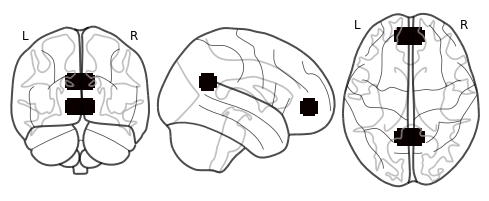

In [16]:
## 10mm radius; 
nilearn.plotting.plot_glass_brain(join(dir_mask, 'DMN', 'Core.nii'))

1.8242093186678414e-10
1.553431760858787e-08
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

early_practice v.s. late_practice: t-test paired samples with Bonferroni correction, P_val=9.772e-03 stat=3.047e+00
early_unpractice v.s. late_unpractice: t-test paired samples with Bonferroni correction, P_val=1.078e-01 stat=2.009e+00


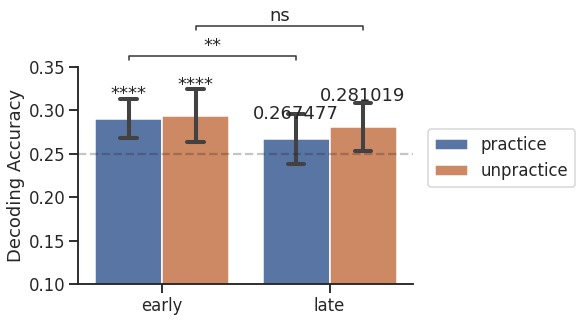

In [19]:
fig, ax = plt.subplots()

data = df[df.ROI=='Core']
x='visit'
y='mean_acc'
hue='mapping'

sns.set(style="ticks", context='talk', font_scale=1.)

ax = sns.barplot(
    data=data
    , x=x, y=y, hue=hue
    , capsize=.1, ci='sd'
    , ax=ax
)
for ii, container in enumerate(ax.containers):
    stage = data.stage.unique()[ii]
    
    A = data[(data.stage==stage)&(data.ROI=='Core')].mean_acc
    B = 0.25
    _, pval = scipy.stats.ttest_1samp(a=A, popmean=B)
    print(pval)

    std = data.groupby(['stage', 'ROI']).std().loc[stage,'Core'].mean_acc
    ax.bar_label(container, labels=[convert_pvalue_to_asterisks(pval)], padding=std*700)
    
ax.set(ylim=[.1, .35])
ax.axhline(y=.25, color='k', linestyle='--', alpha=0.25)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, .75))
# ax.get_legend().remove()
ax.set_xlabel('')
ax.set_ylabel('Decoding Accuracy')

ax, test_results = statannot.add_stat_annotation(
    ax, data=data, x=x, y=y, hue=hue
    , box_pairs=[
        (('early','practice'), ('late', 'practice'))
        , (('early','unpractice'), ('late', 'unpractice'))
    ]
    , test='t-test_paired', text_format='star', loc='outside', verbose=2
#     , line_offset_to_box=0.2, line_offset=0.2, line_height=0.05, text_offset=1,
)
# ax.set(ylim=[.24, .35])
sns.despine()

In [45]:
data

subj            stage   ROI      acc1      acc2      acc3  mean_acc  \
120   01   early_practice  Core  0.447917  0.333333  0.270833  0.350694   
121   02   early_practice  Core  0.239583  0.281250  0.239583  0.253472   
122   05   early_practice  Core  0.208333  0.322917  0.302083  0.277778   
123   07   early_practice  Core  0.291667  0.302083  0.250000  0.281250   
124   08   early_practice  Core  0.302083  0.291667  0.302083  0.298611   
..   ...              ...   ...       ...       ...       ...       ...   
235   36  late_unpractice  Core  0.427083  0.312500  0.260417  0.333333   
236   37  late_unpractice  Core  0.208333  0.291667  0.208333  0.236111   
237   38  late_unpractice  Core  0.312500  0.260417  0.291667  0.288194   
238   42  late_unpractice  Core  0.302083  0.260417  0.260417  0.274306   
239   44  late_unpractice  Core  0.322917  0.333333  0.343750  0.333333   

     visit     mapping  
120  early    practice  
121  early    practice  
122  early    practice  
123  early    practice  
124  early    practice  
..     ...         ...  
235   late  unpractice  
236   late  unpractice  
237   late  unpractice  
238   late  unpractice  
239   late  unpractice  

[120 rows x 9 columns]

In [46]:
dec = data[data.stage=='late_practice'].mean_acc.values-data[data.stage=='early_practice'].mean_acc.values
dec.shape

(30,)

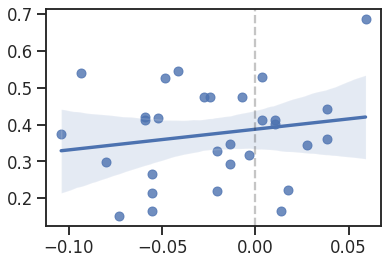

In [50]:
ax = sns.regplot(x=dec, y=behav)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.25)

Bonferroni Post Hoc

In [72]:
from statsmodels.sandbox.stats.multicomp import multipletests

pvals = []

A = data[data.stage=='early_practice'].mean_acc
B = data[data.stage=='late_practice'].mean_acc
ttest = scipy.stats.ttest_rel(A, B)
pvals.append(ttest.pvalue)

A = data[data.stage=='early_unpractice'].mean_acc
B = data[data.stage=='late_unpractice'].mean_acc
ttest = scipy.stats.ttest_rel(A, B)
pvals.append(ttest.pvalue)

reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
print(reject, pvals_corrected)

---

- Dorsomedial sub-regions (dmsub)
    - dorsomedial prefrontal cortex (dmPFC)
    - lateral temporal lobe (LTC)
    - temporoparietal junction (TPJ)
    - middle temporal pole (tempP)

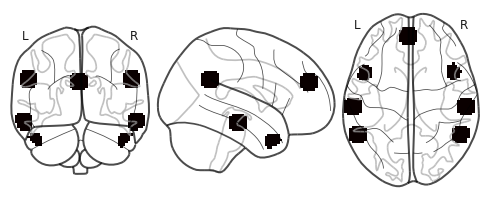

In [79]:
## 10mm radius; dorsomedial sub-regions (dmsub)
nilearn.plotting.plot_glass_brain(join(dir_mask, 'DMN', 'dMsub.nii'))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

early_practice v.s. late_practice: t-test paired samples with Bonferroni correction, P_val=8.180e-02 stat=2.140e+00
early_unpractice v.s. late_unpractice: t-test paired samples with Bonferroni correction, P_val=6.939e-01 stat=9.561e-01


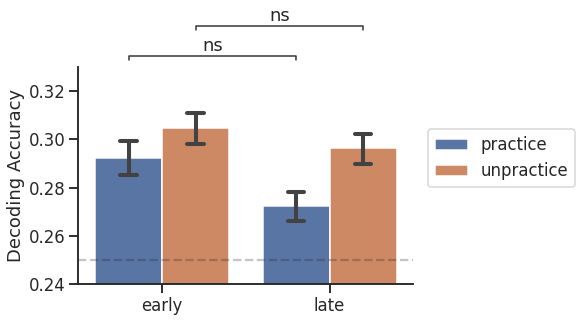

In [78]:
fig, ax = plt.subplots()

data = df[df.ROI=='dMsub']
x='visit'
y='mean_acc'
hue='mapping'

sns.set(style="ticks", context='talk', font_scale=1.)

ax = sns.barplot(
    data=data
    , x=x, y=y, hue=hue
    , capsize=.1, ci=68
    , ax=ax
)
ax.set(ylim=[.24, .33])
ax.axhline(y=.25, color='k', linestyle='--', alpha=0.25)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, .75))
# ax.get_legend().remove()
ax.set_xlabel('')
ax.set_ylabel('Decoding Accuracy')

ax, test_results = statannot.add_stat_annotation(
    ax, data=data, x=x, y=y, hue=hue
    , box_pairs=[
        (('early','practice'), ('late', 'practice'))
        , (('early','unpractice'), ('late', 'unpractice'))
    ]
    , test='t-test_paired', text_format='star', loc='outside', verbose=2
#     , line_offset_to_box=0.2, line_offset=0.2, line_height=0.05, text_offset=1,
)
# ax.set(ylim=[.24, .35])
sns.despine()

---

- Medial Temporal Lobe (MTL)
    - retrosplenial cortex (RSP)
    - (posterior) parahippocampal cortex (PHC)
    - posterior inferior parietal lobe (pIPL)
    - ventromedial preforntal cortex (vmPFC)
    - (anterior) parahippocampal gyrus (HF)

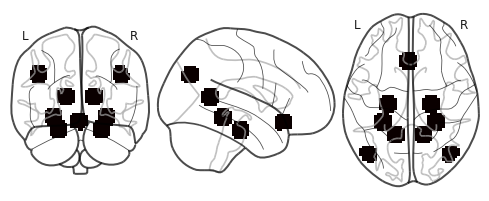

In [82]:
nilearn.plotting.plot_glass_brain(join(dir_mask, 'DMN', 'MTLsub.nii'))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

early_practice v.s. late_practice: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=4.125e-01
early_unpractice v.s. late_unpractice: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=2.026e-01


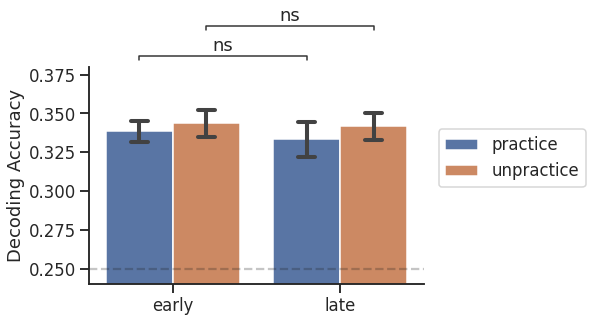

In [81]:
fig, ax = plt.subplots()

data = df[df.ROI=='MTLsub']
x='visit'
y='mean_acc'
hue='mapping'

sns.set(style="ticks", context='talk', font_scale=1.)

ax = sns.barplot(
    data=data
    , x=x, y=y, hue=hue
    , capsize=.1, ci=68
    , ax=ax
)
ax.set(ylim=[.24, .38])
ax.axhline(y=.25, color='k', linestyle='--', alpha=0.25)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, .75))
# ax.get_legend().remove()
ax.set_xlabel('')
ax.set_ylabel('Decoding Accuracy')

ax, test_results = statannot.add_stat_annotation(
    ax, data=data, x=x, y=y, hue=hue
    , box_pairs=[
        (('early','practice'), ('late', 'practice'))
        , (('early','unpractice'), ('late', 'unpractice'))
    ]
    , test='t-test_paired', text_format='star', loc='outside', verbose=2
#     , line_offset_to_box=0.2, line_offset=0.2, line_height=0.05, text_offset=1,
)
# ax.set(ylim=[.24, .35])
sns.despine()

### Fan

In [90]:
fan_info = pd.read_csv(join(dir_mask,'fan280','fan_cluster_net_20200121.csv'), sep=',', index_col=0)

dt = pd.DataFrame()
for network7 in [7]:
    dt = dt.append(fan_info[(fan_info.yeo_7network == network7)])

img_roi = {}
for idx in dt.index:
    label = dt.loc[idx,'label']
    region = dt.loc[idx,'region']

    img_roi[region] = nilearn.image.load_img(
            join(dir_fmri, 'masks/fan280/fan.roi.GA.%03d.nii.gz'%int(label))
    )
    
## Merge them
for ii, img in enumerate(img_roi.values()):
    if ii>0:
        fan = nilearn.image.math_img(img1=fan, img2=img, formula='(img1+img2)>0')
    else:
        fan = img

In [92]:
nilearn.plotting.plot_roi(fan)

In [25]:
fan.get_fdata().sum()

9712.0

- common ground

In [22]:
tmp = niimg.image.math_img(img1=dump, img2=fan, formula='img1*img2')

In [23]:
nilearn.plotting.plot_roi(tmp)

In [26]:
tmp.get_fdata().sum()

1341.0

### *t-test (Optional)

In [16]:
def wit_df_paired_t_test(wit_df, cond_A, cond_B):
    ## cond_A vs. cond_B :
    ### early_practice vs. late_practice
    ### early_unpractice vs. late_unpractice
    ### early_practice vs. early_unpractice
    ### late_practice vs. late_unpractice
    a1, a2 = cond_A.split('_')
    assert a1 in ['early', 'late']
    assert a2 in ['practice', 'unpractice']
    b1, b2 = cond_B.split('_')
    assert b1 in ['early', 'late']
    assert b2 in ['practice', 'unpractice']

    pvals = {}
    
    ROI_list = wit_df.ROI.unique()
    for roi in ROI_list:
        A = wit_df[(wit_df.ROI==roi)&(wit_df.visit==a1)&(wit_df.mapping==a2)]['mean_accuracy']
        B = wit_df[(wit_df.ROI==roi)&(wit_df.visit==b1)&(wit_df.mapping==b2)]['mean_accuracy']
        ttest = scipy.stats.ttest_rel(A, B)
        pvals[roi,cond_A+'/'+cond_B] = statsmodels.stats.multitest.fdrcorrection(ttest.pvalue)
        
    return pvals

In [11]:
# for subj in subj_list:
#     betas = {}
#     for stage in stage_list:
#         beta = load_betas(subj, stage)
#         betas[subj, stage] = beta[subj, stage]
#     ## Save betas
#     with open(join(fmri_dir,'beta.%s.pkl'%subj),'wb') as fw:
#         pickle.dump(betas, fw)

## load betas from $pickle$

In [10]:
# betas = {}
# for subj in subj_list:
#     with open(join(fmri_dir,'beta.%s.pkl'%subj),'rb') as fr:
#         betas.update(pickle.load(fr))

## Movement-related ROIs from localizer

In [ ]:
ROI_imgs = {}
## ROIs
path_list = sorted(glob(join(mask_dir,'localizer','n200_*.nii')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    ROI_imgs[roi] = niimg.load_img(path)

In [ ]:
# title_list = ['Left Precentral'
#               , 'Left Postcentral'
#               , 'Right Cerebellum IV-V'
#               , 'Right Postcentral'
#               , 'Left Putamen'
#               , 'Right SMA'
#               , 'Right Cerebellum VIIIb'
#               , 'Left Thalamus']
# idx_list = [0, 1, 4, 7, 9, 11, 12, 14]
# ncol = 4
# nrow = 4
# magn = 8
# _, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))
# axes = np.concatenate(axes)
# cnt = 0
# for i, (name, img) in enumerate(ROI_imgs.items()):
#     if not i in idx_list:
#         continue
#     print(name, end='\r')
#     ax = draw_lineplot(wit_df, roi_name=name, title=title_list[cnt], ax=axes[cnt+(cnt//ncol)*ncol])
#     nplt.plot_roi(roi_img=img, bg_img=img_bg, title=name
#                   , draw_cross=False, black_bg=False
#                   , display_mode='ortho', axes=axes[cnt+(cnt//ncol)*ncol+ncol])
#     cnt += 1

# *Ventral visual stream

In [19]:
roi_imgs = {}
## ROIs
path_list = glob(join(mask_dir, 'TT_Daemon', '*.brik1.BA???.*.nii.gz'))
for path in path_list:
    temp = path.split('/')[-1].replace('.nii.gz', '')
    fname = temp.split('.')[2]
    roi_imgs[fname] = nilearn.image.load_img(path)

## calculating

In [18]:
scores = {}
for subj in subj_list:
    betas = {}
    for stage in stage_list:
        beta = load_betas(subj, stage)
        betas[subj, stage] = beta[subj, stage]
    scores.update(cross_valid(betas, roi_imgs, lda))

## save the result
pickle_name = 'visual_stream'
with open(join(script_dir, today+'_%s.pkl'%pickle_name),"wb") as fw:
    pickle.dump(scores, fw)

### *create wit_df

In [20]:
temp = show_pkl_list(script_dir, 'visual_stream')
temp

name identity
0  20210303_visual_stream.pkl        a
1  20210304_visual_stream.pkl        a
2  20210215_visual_stream.pkl        b

In [22]:
with open(temp.loc[1,'name'],"rb") as fr:
    scores = pickle.load(file=fr)
# roi_names = sorted(set([rr for _, _, rr in scores.keys()]))

In [23]:
wit_df = make_wit_df(scores)
wit_df

subj    ROI  visit     mapping  accuracy_1  accuracy_2  accuracy_3  \
0      01  BA17L  early    practice    0.729167    0.718750    0.802083   
1      01  BA17R  early    practice    0.687500    0.635417    0.552083   
2      01  BA18L  early    practice    0.760417    0.791667    0.833333   
3      01  BA18R  early    practice    0.750000    0.812500    0.750000   
4      01  BA19L  early    practice    0.583333    0.510417    0.572917   
...   ...    ...    ...         ...         ...         ...         ...   
1435   44  BA20R   late  unpractice    0.312500    0.354167    0.343750   
1436   44  BA37L   late  unpractice    0.343750    0.375000    0.302083   
1437   44  BA37R   late  unpractice    0.354167    0.437500    0.322917   
1438   44  BA38L   late  unpractice    0.322917    0.333333    0.281250   
1439   44  BA38R   late  unpractice    0.343750    0.343750    0.270833   

      mean_accuracy  
0          0.750000  
1          0.625000  
2          0.795139  
3          0.770833  
4          0.555556  
...             ...  
1435       0.336806  
1436       0.340278  
1437       0.371528  
1438       0.312500  
1439       0.319444  

[1440 rows x 8 columns]

### *visualization

In [24]:
sns.set(style="ticks", context='talk')
palette = ['#00A8AA','#C5C7D2']

def draw_lineplot(wit_df, roi_name, title, ax=None):
    
    sub_df = wit_df[wit_df.ROI == roi_name]
    ax = sns.pointplot(x='visit', y='mean_accuracy', hue='mapping', data=sub_df, ax=ax
                       , palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    ax.set_xlim((-0.4, 1.4))
    ax.set_ylim(0.225, 0.55)
    ax.set_yticks(np.arange(.25,.90,.15))
    ax.set_ylabel('Decoding Accuracy')
    ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.25)
#     ax.get_legend().remove()
    ax.legend(loc='best', frameon=True)
    ax.set_title(title)
    
    return ax

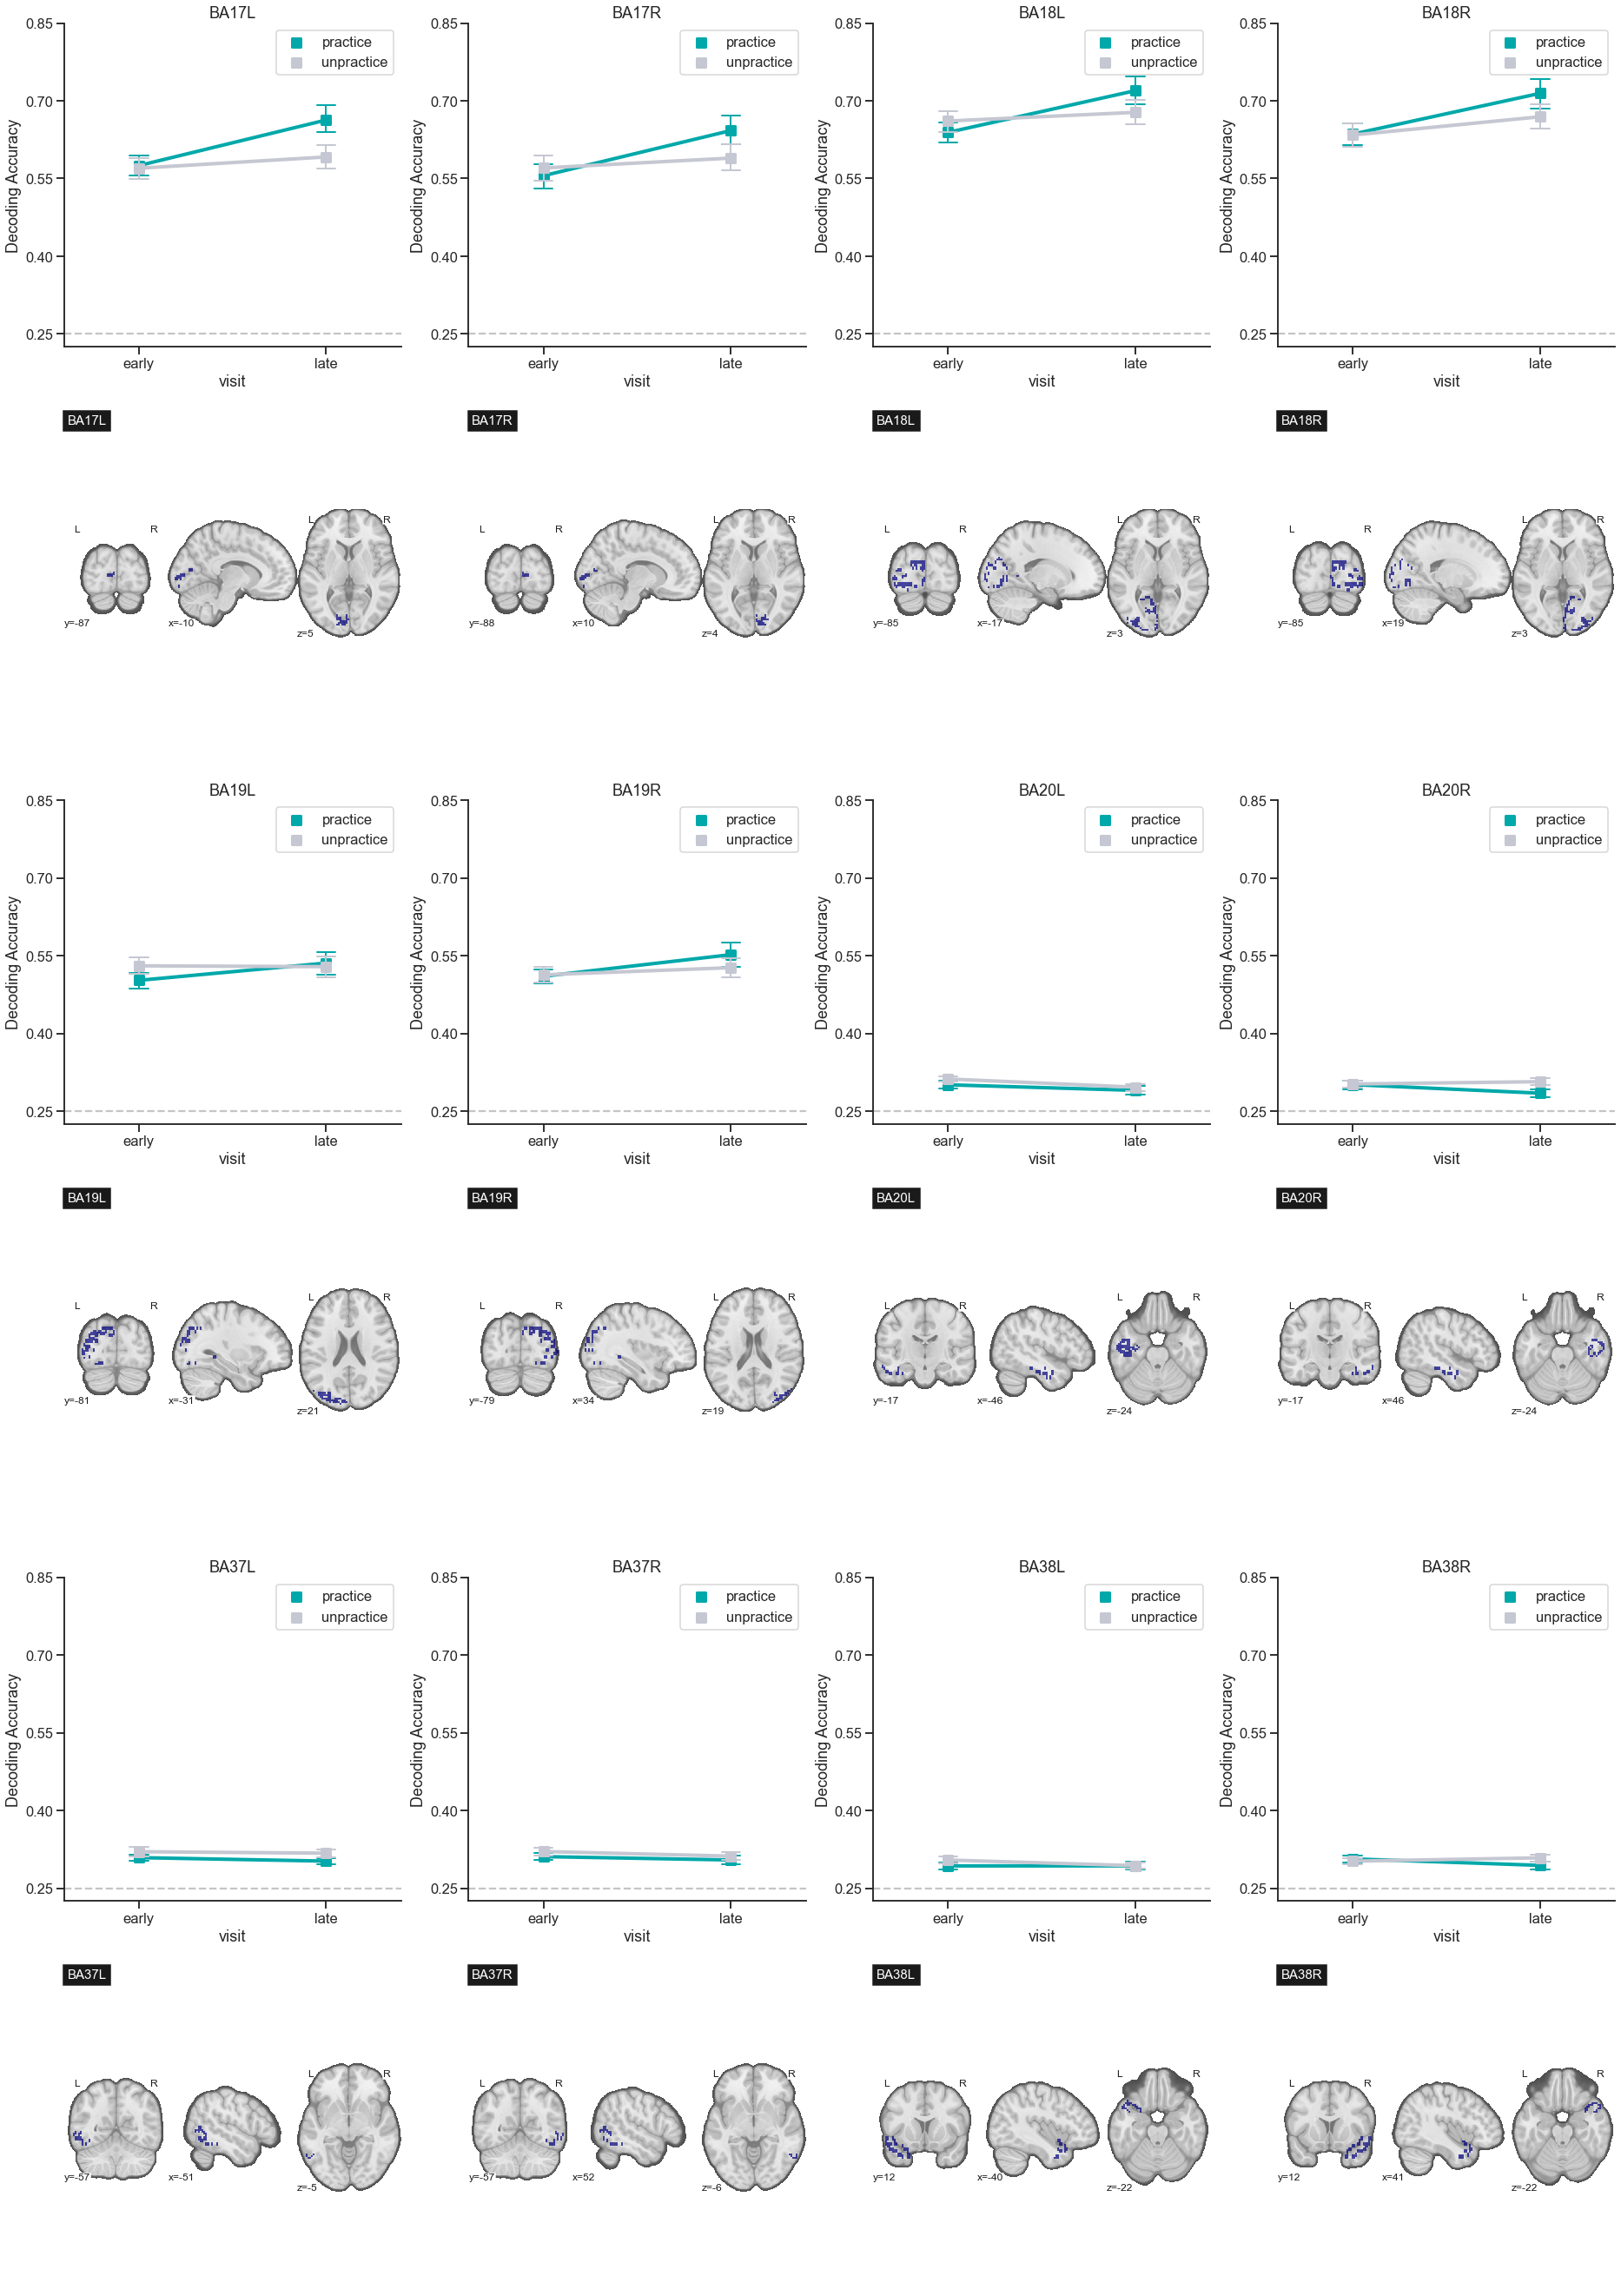

In [26]:
magn = 8   # a size of figures
ncol = 4   # a number of columns

nrow = 2*len(roi_imgs.keys())//ncol   # a number of rows
_, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))
axes = np.concatenate(axes)
for i, (name, img) in enumerate(roi_imgs.items()):
    print(name, end='\r')
    ax = draw_lineplot(wit_df, roi_name=name, title=name, ax=axes[i+(i//ncol)*ncol])
    nplt.plot_roi(roi_img=img, bg_img=img_bg, title=name
                  , draw_cross=False, black_bg=False
                  , display_mode='ortho', axes=axes[i+(i//ncol)*ncol+ncol])

## *Whole-brain analysis with Fan280

In [20]:
with open(join(mask_dir,'fan280','fan280_fullname.csv'),'rb') as fb:
    fan_list = pd.read_csv(fb, header=None)

In [21]:
fan_imgs={}
path_list = glob(join(mask_dir,'fan280','*.nii.gz'))
for path in path_list:
    temp = path.split('/')[-1].replace('.nii.gz', '')
    fname = temp.split('.')[-1]
    fan_imgs[fname] = nilearn.image.load_img(path)

In [22]:
## LDA analysis
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', n_components=2)

In [23]:
nrun = 3
cv = GroupKFold(nrun)
y = np.array([j for i in range(nrun) for j in target_pos]) ## answer : [5, 25, 21, 1, 25,...]
group = np.array([i for i in range(nrun) for j in target_pos]) ## run number : [0, 0, ..., 1, 1, ..., 2, 2]

In [24]:
subj = '01'
stage = 'late_practice'
beta = load_betas(subj, stage)

In [25]:
X = fast_masking(img=beta[subj,stage], roi=roi_imgs['BA17L']) # (trial,voxel)
X_scaled = StandardScaler().fit_transform(X)
X_scaled.shape

(288, 157)

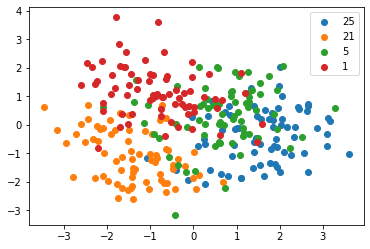

In [26]:
temp = lda.fit_transform(X_scaled, y)

for target in list(set(target_pos)):
    plt.scatter(temp[y==target,0], temp[y==target,1], label=target)
    plt.legend(loc='best', shadow=False, scatterpoints=1)

In [29]:
ypred = np.zeros(len(y))
scores = np.zeros(3)
for i, (idx_train, idx_test) in enumerate(cv.split(X, y, group)):
    Xtrain = X_scaled[idx_train]
    ytrain = y[idx_train]
    temp = lda.fit_transform(Xtrain, ytrain)
    
    Xtest = X_scaled[idx_test]
    ypred[idx_test] = lda.predict(Xtest)
    scores[i] = lda.score(Xtest,y[idx_test])

rval, pval = scipy.stats.pearsonr(y,ypred)
print(rval, pval, np.mean(scores))

0.24137062767365788 3.4768137129058844e-05 0.4791666666666667


### visual stream (Brodmann Area)

Accuracy = (TP+TN)/(TP+TN+FP+FN)\
Precision = TP/(TP+FP)\
Recall = TP/(TP+FN)

In [32]:
# df = pd.DataFrame(columns=['subj','stage','region','n_voxels','pval','rval','accuracy'])
df = pd.DataFrame(columns=['subj','stage','region','n_voxels','accuracy'])
for subj in subj_list:
    for stage in ['early_practice','late_practice']:
        beta = load_betas(subj, stage)
        for name, img in roi_imgs.items():
            X = fast_masking(img=beta[subj,stage], roi=img) # (trial,voxel)
            if X.shape[-1]<=3:
                continue
            X_scaled = StandardScaler().fit_transform(X)
            X_scaled.shape
#             ypred = np.zeros(len(y))
            scores = np.zeros(nrun)
            for i, (idx_train, idx_test) in enumerate(cv.split(X, y, group)):
                Xtrain = X_scaled[idx_train]
                ytrain = y[idx_train]
                temp = lda.fit_transform(Xtrain, ytrain)

                Xtest = X_scaled[idx_test]
#                 ypred[idx_test] = lda.predict(Xtest)
                
                scores[i] = lda.score(Xtest,y[idx_test])
#             rval, pval = scipy.stats.pearsonr(y,ypred)
            df = df.append(
                {'subj':subj
                 , 'stage':stage
                 , 'region':name
                 , 'n_voxels':X.shape[-1]
#                  , 'pval':pval, 'rval':rval
                 , 'accuracy':np.mean(scores)}
#                  , 'accuracy':sum(ypred==y)/len(y)
                , ignore_index=True)
df.to_csv(join(script_dir,today+'.lda.visual_stream.csv'),index=False)
df

subj           stage region n_voxels  accuracy
0     01  early_practice  BA17L      157  0.750000
1     01  early_practice  BA17R      151  0.625000
2     01  early_practice  BA18L      724  0.795139
3     01  early_practice  BA18R      717  0.770833
4     01  early_practice  BA19L      761  0.555556
..   ...             ...    ...      ...       ...
715   44   late_practice  BA20R      359  0.305556
716   44   late_practice  BA37L      308  0.312500
717   44   late_practice  BA37R      302  0.343750
718   44   late_practice  BA38L      304  0.298611
719   44   late_practice  BA38R      302  0.340278

[720 rows x 5 columns]

[(0.0, 0.8)]

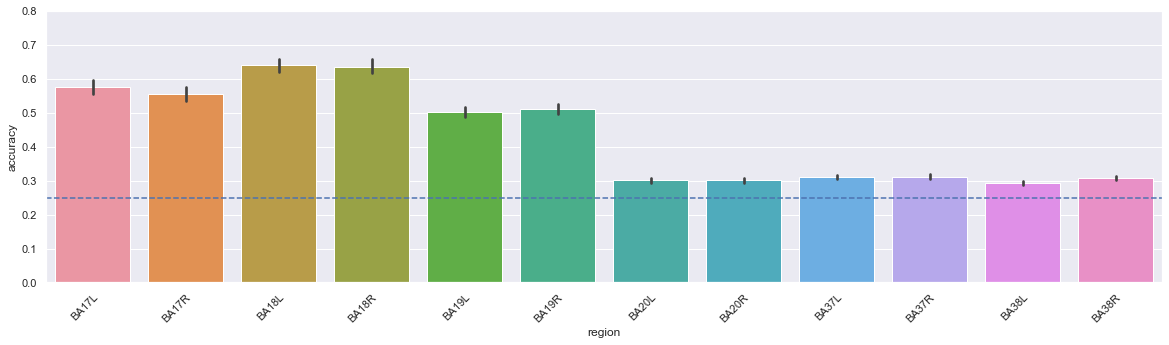

In [34]:
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.barplot(data=df[df.stage=='early_practice'], x='region', y='accuracy', ci=68)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.25, ls='--')
ax.set(ylim=(0, 0.8))

[(0.0, 0.8)]

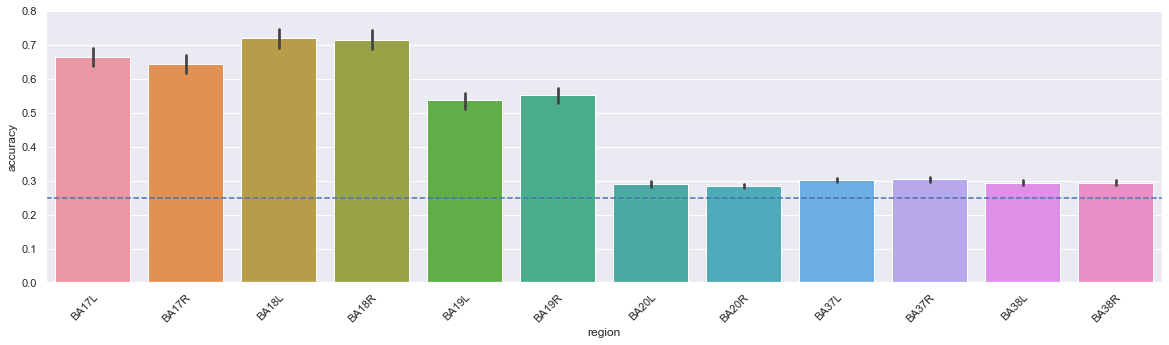

In [35]:
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.barplot(data=df[df.stage=='late_practice'], x='region', y='accuracy', ci=68)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.25, ls='--')
ax.set(ylim=(0, 0.8))

### fan roi

In [36]:
df = pd.DataFrame(columns=['subj','stage','fan','region','n_voxels','accuracy'])
for subj in subj_list:
    for stage in ['early_practice','late_practice']:
        beta = load_betas(subj, stage)
        for num, img in fan_imgs.items():
            X = fast_masking(img=beta[subj,stage], roi=img) # (trial,voxel)
            if X.shape[-1]<=3:
                continue
            X_scaled = StandardScaler().fit_transform(X)
            X_scaled.shape
#             ypred = np.zeros(len(y))
            scores = np.zeros(nrun)
            for i, (idx_train, idx_test) in enumerate(cv.split(X, y, group)):
                Xtrain = X_scaled[idx_train]
                ytrain = y[idx_train]
                temp = lda.fit_transform(Xtrain, ytrain)

                Xtest = X_scaled[idx_test]
#                 ypred[idx_test] = lda.predict(Xtest)
                scores[i] = lda.score(Xtest,y[idx_test])
#             rval, pval = scipy.stats.pearsonr(y,ypred)
            df = df.append(
                {'subj':subj
                 , 'stage':stage
                 , 'fan':num
                 , 'region':fan_list.loc[int(num)-1,0]
                 , 'n_voxels':X.shape[-1]
#                  , 'pval':pval, 'rval':rval
                 , 'accuracy':np.mean(scores)}
                , ignore_index=True)
df.to_csv(join(script_dir,today+'.lda.fan280.csv'),index=False)
df

subj           stage  fan  \
0       01  early_practice  001   
1       01  early_practice  002   
2       01  early_practice  003   
3       01  early_practice  004   
4       01  early_practice  005   
...    ...             ...  ...   
16615   44   late_practice  274   
16616   44   late_practice  275   
16617   44   late_practice  276   
16618   44   late_practice  277   
16619   44   late_practice  278   

                                               region n_voxels  accuracy  
0            Lt. superior frontal gyrus (BA8, medial)      286  0.298611  
1            Rt. superior frontal gyrus (BA8, medial)      331  0.364583  
2      Lt. superior frontal gyrus (BA8, dorsolateral)      359  0.291667  
3      Rt. superior frontal gyrus (BA8, dorsolateral)      279  0.263889  
4           Lt. superior frontal gyrus (BA9, lateral)      321  0.315972  
...                                               ...      ...       ...  
16615                                    Hypothalamus      116  0.260417  
16616                                       Brainstem     1189  0.263889  
16617                             Periaqueductal gray      132  0.284722  
16618                            Lt. substantia nigra       18  0.295139  
16619                            Rt. substantia nigra       25  0.239583  

[16620 rows x 6 columns]

In [17]:
# temp = glob(join(script_dir,'*.lda.fan280.csv'))
# temp

In [18]:
# df = pd.read_csv(temp[0])
# df

[(0.0, 0.8)]

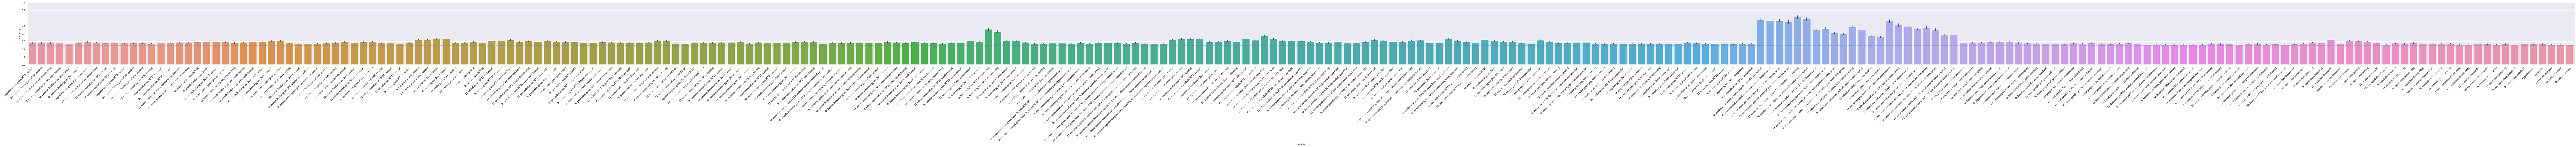

In [52]:
sns.set(rc={'figure.figsize':(200,5)})
ax = sns.barplot(data=df[df.stage=='early_practice'], x='region', y='accuracy', ci=68)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.25, ls='--')
ax.set(ylim=(0, 0.8))

[(0.0, 0.8)]

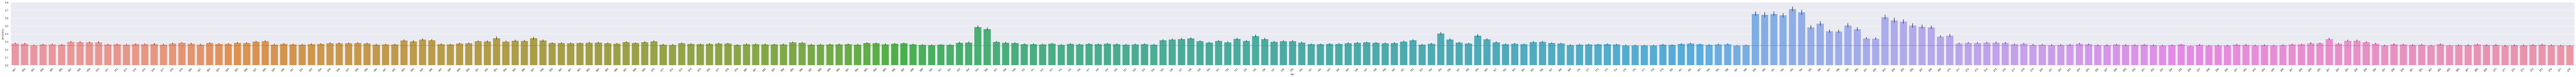

In [42]:
sns.set(rc={'figure.figsize':(200,5)})
ax = sns.barplot(data=df[df.stage=='late_practice'], x='fan', y='accuracy', ci=68)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.25, ls='--')
ax.set(ylim=(0, 0.8))

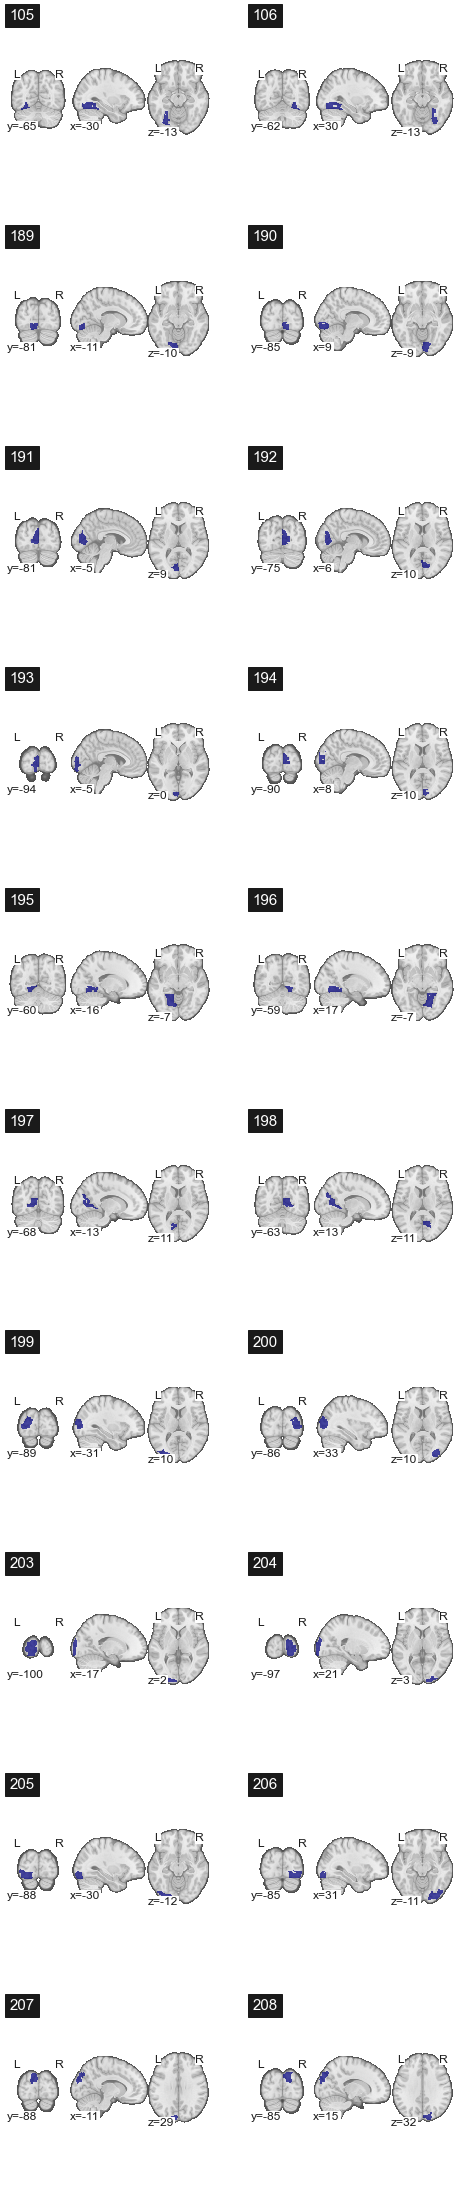

In [54]:
rois = ['105','106'
        ,'189','190','191','192','193','194','195','196','197','198','199','200'
        ,'203','204','205','206','207','208']

magn = 4   # a size of figures
ncol = 2   # a number of columns

nrow = len(rois)//ncol   # a number of rows
_, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))
axes = np.concatenate(axes)
i = 0
for num, img in fan_imgs.items():
    if not num in rois:
        continue
    print(num, end='\r')
    nplt.plot_roi(roi_img=img, bg_img=img_bg, title=num
                  , draw_cross=False, black_bg=False
                  , display_mode='ortho', axes=axes[i])
    i += 1

# *SearchLight

Searchlight analysis was introduced in Information-based functional brain mapping (Kriegeskorte et al., 2006), and consists of scanning the brain with a $\textit{searchlight}$. Briefly, a ball of given radius is scanned across the brain volume and the prediction accuracy of a classifier trained on the corresponding voxels is measured.

SearchLight will iterate on the volume and give a score to each voxel. This score is computed by running a classifier on selected voxels. In order to make this score as accurate as possible (and avoid overfitting), cross-validation is used.

An important parameter is the radius of the sphere that will run through the data. The sphere size determines the number of voxels/features to use for classification (i.e. more voxels are included with larger spheres).